In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import numpy as np

In [3]:
def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

# Controle Cinemático

In [3]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

# Depois do import do numpy (caso já não tenha sido feito):
import numpy as np
import time

# ...
# Logo após o trecho "while True:", declare as seguintes variáveis:

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)     
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
               
    
    prev_error = np.zeros(3)  # Armazena os erros anteriores (inicializados em zero)
    sum_error = np.zeros(3)   # Armazena a soma acumulada dos erros (inicializados em zero)
    prev_time = time.time()   # Armazena o tempo anterior (para cálculo do termo derivativo)
 
    # Robotino
    L = 0.225  # Metros
    r = 0.06  # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
           
    # Goal configuration (x, y, theta)    
    qgoal = np.array([2, 2, np.deg2rad(180)])
    #qgoal = np.array([3, -3, np.deg2rad(-90)])
    #qgoal = np.array([0, 0, np.deg2rad(0)])
     
    qdot = np.zeros(3)

    # Frame que representa o Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)     
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)

    error = np.zeros(3)
    gain = np.array([[3, 0, 0], [0, 3, 0], [0, 0, 3]])
    #gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    
    lista_q0 = []
    lista_q1 = []
    lista_q2 = []
   
    lista_u0 = []
    lista_u1 = []
    lista_u2 = []

    lista_erro_posicao = []

    start_time_simulation = time.time()  # Tempo no início da iteração
    end_time = time.time()
    # Lembrar de habilitar o 'Real-time mode'
    while True:
        
        start_time_loop = time.time()  # Tempo no início da iteração

        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        q = np.array([pos[0], pos[1], ori[2]])
        
        
        error[:2] = qgoal[:2] - q[:2]
        
        #error do angulo normalizado
        error[2] = qgoal[2] - q[2]
        error[2] = (error[2] + np.pi) % (2 * np.pi) - np.pi
        
        durantion_time = end_time - start_time_simulation
        # Margem aceitável de distância
        # if (np.linalg.norm(error[:2]) < 0.005):
        #     break

        lista_erro_posicao.append(np.linalg.norm(error[:2]))
        

        if (durantion_time >= 5*60):
            break

        # or (np.linalg.norm(error[:2]) < 0.005 and (q[2] - qgoal[2] < 0.1)):

        # Controller
        # Controller PID
        current_time = time.time()
        dt = current_time - prev_time  # Cálculo do tempo decorrido
        prev_time = current_time

        # Cálculo dos termos PID   
        kp = 3
        ki = 0
        kd = 0
        
        # Cálculo dos termos PID
        proportional_x = kp * error[0]
        integral_x = ki * sum_error[0]
        derivative_x = kd * (error[0] - prev_error[0]) / dt

        proportional_y = kp* error[1]
        integral_y = ki * sum_error[1]
        derivative_y = kd * (error[1] - prev_error[1]) / dt

        proportional_theta = kp* error[2]
        integral_theta = ki * sum_error[2]
        derivative_theta = kd * (error[2] - prev_error[2]) / dt


        # Atualização da soma acumulada dos erros para o termo integral
        # error_max = 50

        # if error.any() < error_max : 
        sum_error += ((error + prev_error)/2)*(dt)

        # Atualização do erro anterior para o termo derivativo
        prev_error = error.copy()

        # Sinal de controle final
        qdot[0] = proportional_x + integral_x + derivative_x
        qdot[1] = proportional_y + integral_y + derivative_y
        qdot[2] = proportional_theta + integral_theta + derivative_theta

        # Cinemática Inversa
        # w1, w2, w3
        Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
        u = Minv @ qdot

        relacao_reducao = 32
        u = u / relacao_reducao

        # Limite a velocidade máxima em rad/s
        velocidade_maxima = 377
        u = np.clip(u, -velocidade_maxima, velocidade_maxima)


        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
        sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
        sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)          

        lista_q0.append(q[0])
        lista_q1.append(q[1])
        lista_q2.append(q[2])

        lista_u0.append(u[0]) 
        lista_u1.append(u[1])
        lista_u2.append(u[2])

        end_time = time.time()
        loop_duration = end_time - start_time_loop  # Duração da iteração em segundos
    print("Duração do loop: ", loop_duration, "segundos")

    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)

    end_time_simulation = time.time()

else:
    print ('Failed connecting to remote API server')

simulation_time = end_time_simulation - start_time_simulation
print(f'Duração da simulação {simulation_time}')    
print ('Program ended')

Program started
Connected to remote API server


KeyboardInterrupt: 

### Salvar Arquivos

In [3]:
import numpy as np
import csv

# Função para salvar dados em um arquivo CSV
def salvar_dados_em_csv(nome_arquivo, lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao):
    with open(nome_arquivo, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Escreve o cabeçalho
        writer.writerow(["q0", "q1", "q2", "u0", "u1", "u2", "erro_posicao"])
        
        # Escreve os dados
        for q0, q1, q2, u0, u1, u2, erro_pos in zip(lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao):
            writer.writerow([q0, q1, q2, u0, u1, u2, erro_pos])

# Após a simulação, chame a função para salvar os dados
nome_arquivo = 'dados_simulacao_pid.csv'
salvar_dados_em_csv(nome_arquivo, lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao)

print(f'Dados salvos em {nome_arquivo}')


Dados salvos em dados_simulacao_pid.csv


### Ler Arquivo

In [1]:
import csv

# Função para ler dados de um arquivo CSV e atribuir às variáveis correspondentes
def ler_dados_de_csv(nome_arquivo):
    lista_q0 = []
    lista_q1 = []
    lista_q2 = []
    lista_u0 = []
    lista_u1 = []
    lista_u2 = []
    lista_erro_posicao = []

    with open(nome_arquivo, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Pula o cabeçalho
        for row in reader:
            lista_q0.append(float(row[0]))
            lista_q1.append(float(row[1]))
            lista_q2.append(float(row[2]))
            lista_u0.append(float(row[3]))
            lista_u1.append(float(row[4]))
            lista_u2.append(float(row[5]))
            lista_erro_posicao.append(float(row[6]))

    return lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao

# Exemplo de uso para ler os dados
# nome_arquivo = 'dados_simulacao.csv'
lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao = ler_dados_de_csv(nome_arquivo)

NameError: name 'nome_arquivo' is not defined

In [4]:
import numpy as np

# Seu código para coletar os dados (lista_q0, etc.)

# Valor final desejado (pode ser a posição desejada ou outro valor)
valor_final = qgoal[0]

# Limite para considerar a resposta como assentada (2% do valor final)
limite_assentamento = 0.02 * valor_final

# Variável para armazenar o tempo de assentamento
tempo_assentamento = None

# Percorra a lista de posições e encontre o tempo em que a resposta permanece dentro do limite
for tempo, posicao in enumerate(lista_erro_posicao):
    if np.abs(posicao - valor_final) < limite_assentamento:
        if tempo_assentamento is None:
            tempo_assentamento = tempo

# Se o tempo de assentamento foi encontrado, imprima-o
if tempo_assentamento is not None:
    print(f"Tempo de Assentamento: {tempo_assentamento*loop_duration} unidades de tempo")  # Você precisa converter para segundos, se necessário
else:
    print("Não foi possível determinar o tempo de assentamento")


Tempo de Assentamento: 3.0347089767456055 unidades de tempo


In [5]:
import matplotlib.pyplot as plt

In [6]:

print("Duração do loop: ", loop_duration, "segundos")
len(lista_q0)*loop_duration

Duração do loop:  0.1083824634552002 segundos


313.22531938552856

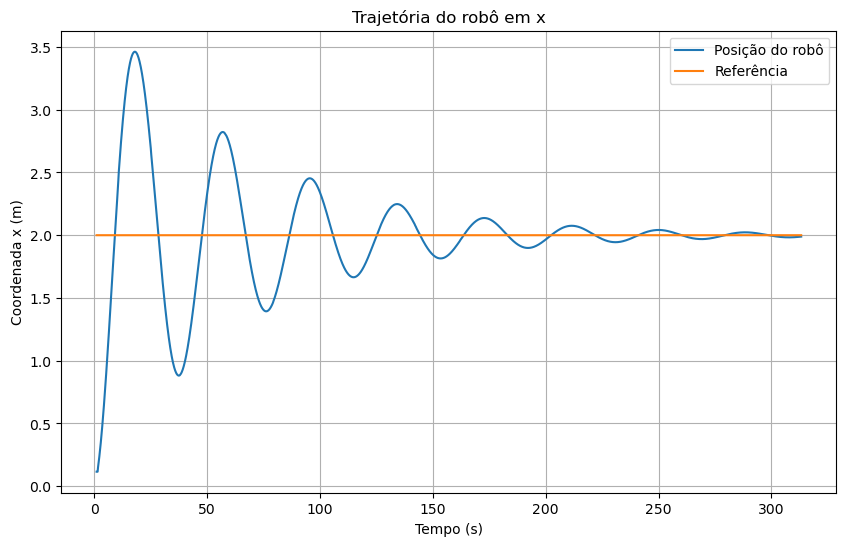

In [7]:
import matplotlib.pyplot as plt

x = np.linspace(1, len(lista_q0)*loop_duration, len(lista_q0))
plt.figure(figsize=(10, 6))

plt.plot(x,lista_q0, label = 'Posição do robô')
plt.plot(x,qgoal[0]*np.ones(len(lista_q0)), label = 'Referência')
plt.title('Trajetória do robô em x', fontsize = 12 )
plt.xlabel('Tempo (s)')
plt.ylabel('Coordenada x (m)')
plt.legend()
plt.grid(True)
# plt.savefig('Trajetória_X_final_PID.png', dpi = 1500)
plt.show()

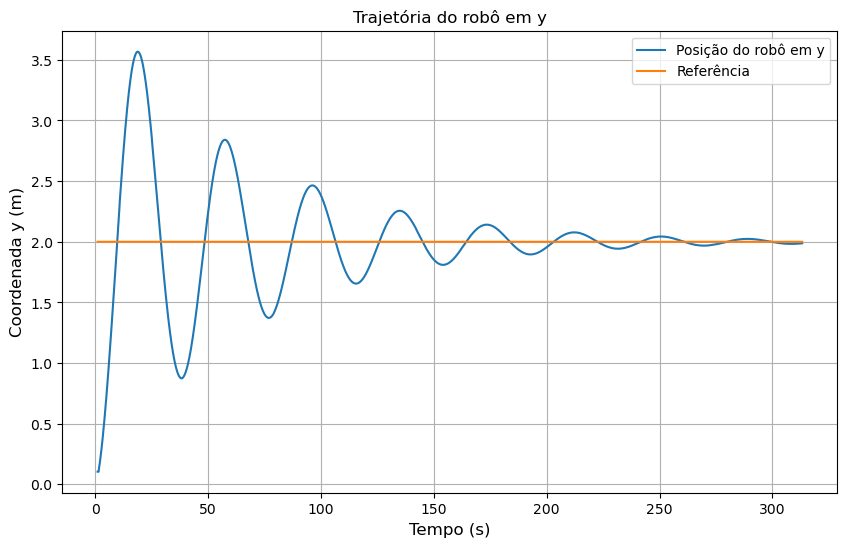

In [8]:
x = np.linspace(1, len(lista_q1)*loop_duration, len(lista_q1))
plt.figure(figsize=(10, 6))

plt.plot(x,lista_q1, label = 'Posição do robô em y')
plt.plot(x,qgoal[1]*np.ones(len(lista_q1)), label = 'Referência')

plt.title('Trajetória do robô em y')
plt.xlabel('Tempo (s)', fontsize = 12)
plt.ylabel('Coordenada y (m)',  fontsize = 12)
plt.legend()
plt.grid(True)

# plt.savefig('Trajetória_Y_final_PID.png', dpi = 1500)

plt.show()

### Personalizar gráfico de trajetória do robô

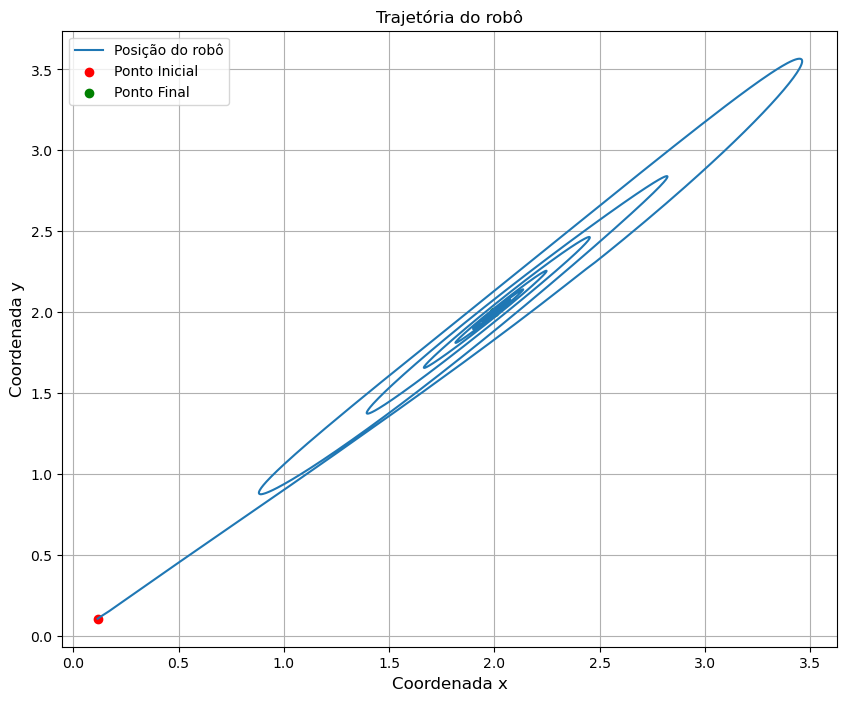

In [9]:
import matplotlib.pyplot as plt

# Seu código existente

x = np.linspace(1, len(lista_q1) * loop_duration, len(lista_q1))
plt.figure(figsize=(10, 8))

plt.plot(lista_q0, lista_q1, label='Posição do robô')
plt.scatter(lista_q0[0], lista_q1[0], color='red', marker='o', label='Ponto Inicial')

plt.title('Trajetória do robô', fontsize = 12)
plt.xlabel('Coordenada x', fontsize = 12)
plt.ylabel('Coordenada y',fontsize = 12)

# Plotagem do ponto final (2, 2)
plt.scatter(qgoal[0],qgoal[1], color='green', marker='o', label='Ponto Final')

plt.legend()
plt.grid(True)
# plt.savefig('Trajetória_robo_final_TCC_PID.png', dpi = 1500)

plt.show()


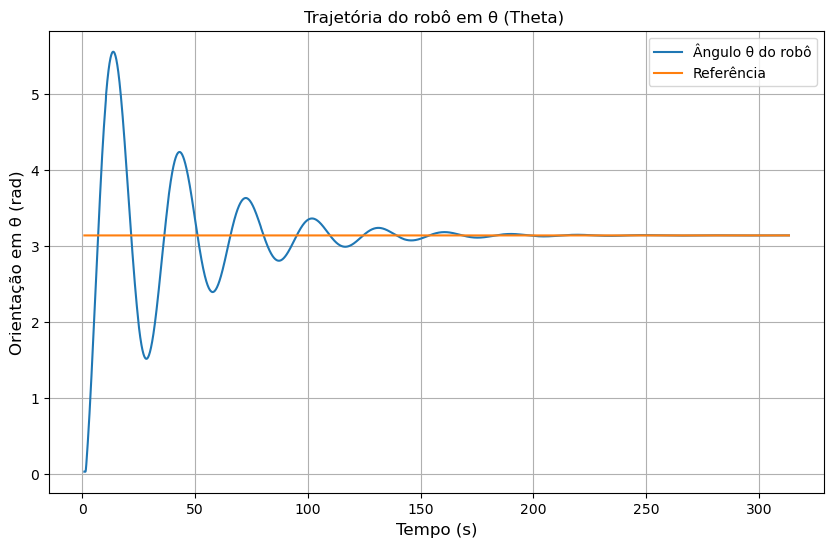

In [10]:
import matplotlib.pyplot as plt

# Seu código existente

x = np.linspace(1, len(lista_q2) * loop_duration, len(lista_q2))
plt.figure(figsize = (10, 6))

# Desnormalizando o ângulo para -π a π
unwrapped_q2 = np.unwrap(lista_q2)

plt.plot(x, -unwrapped_q2)
plt.plot(x, qgoal[2] * np.ones(len(lista_q2)))
plt.title('Trajetória do robô em θ (Theta) ')
plt.ylabel('Orientação em θ (rad)', fontsize = 12)
plt.xlabel('Tempo (s)', fontsize = 12)
plt.grid(True)
plt.legend(['Ângulo θ do robô', 'Referência'])

# plt.savefig('Trajetória_theta_final_PID.png', dpi = 1500)

plt.show()

In [ ]:
ø1 

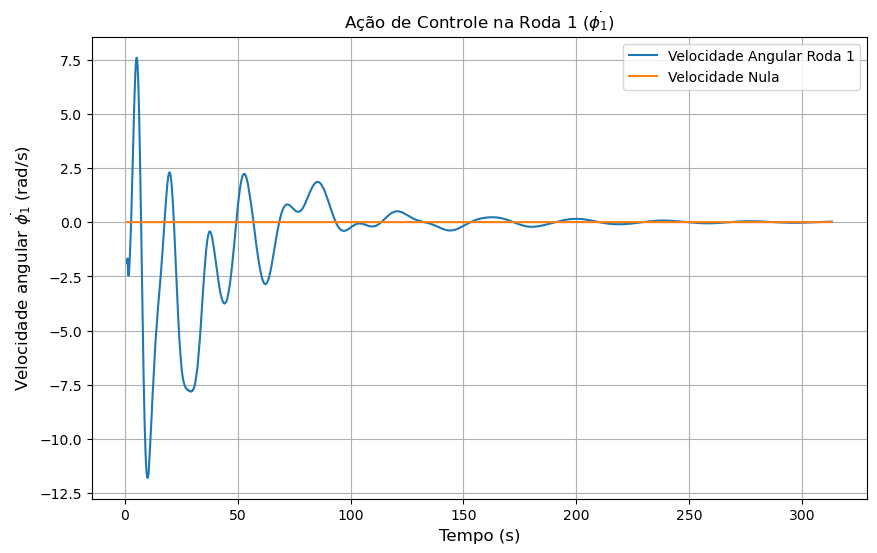

In [11]:
x = np.linspace(1, len(lista_u0)*loop_duration, len(lista_u0))
plt.figure(figsize = (10, 6))

plt.plot(x,lista_u0)
plt.plot(x,0*np.ones(len(lista_u0)))
plt.title('Ação de Controle na Roda 1 ($\dot{\phi_1}$)')
plt.ylabel('Velocidade angular $\dot{\phi_1}$ (rad/s)', fontsize = 12)
plt.xlabel('Tempo (s)', fontsize = 12)

plt.grid(True)
plt.legend(['Velocidade Angular Roda 1','Velocidade Nula'])

# plt.savefig('Acao_Controle_motor1_TCC_PID.png', dpi = 1500)

plt.show()

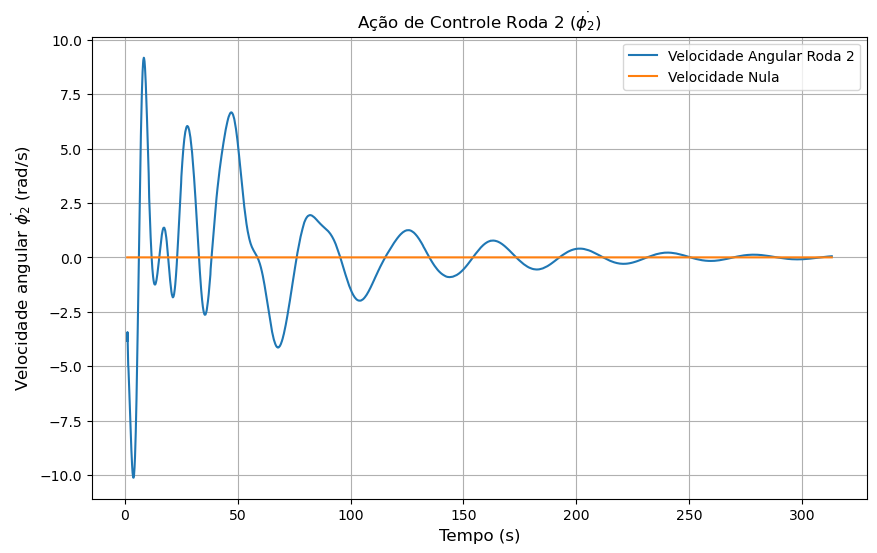

In [12]:
x = np.linspace(1, len(lista_u1)*loop_duration, len(lista_u1) )
plt.figure(figsize = (10, 6))

plt.plot(x,lista_u1)
plt.plot(x,0*np.ones(len(lista_u1)))
plt.title('Ação de Controle Roda 2 ($\dot{\phi_2}$)')
plt.ylabel('Velocidade angular $\dot{\phi_2}$ (rad/s)', fontsize = 12)
plt.xlabel('Tempo (s)', fontsize = 12)
plt.grid(True)
plt.legend(['Velocidade Angular Roda 2','Velocidade Nula'])
# plt.savefig('Acao_Controle_motor2_PID.png', dpi = 1500 )
plt.show()

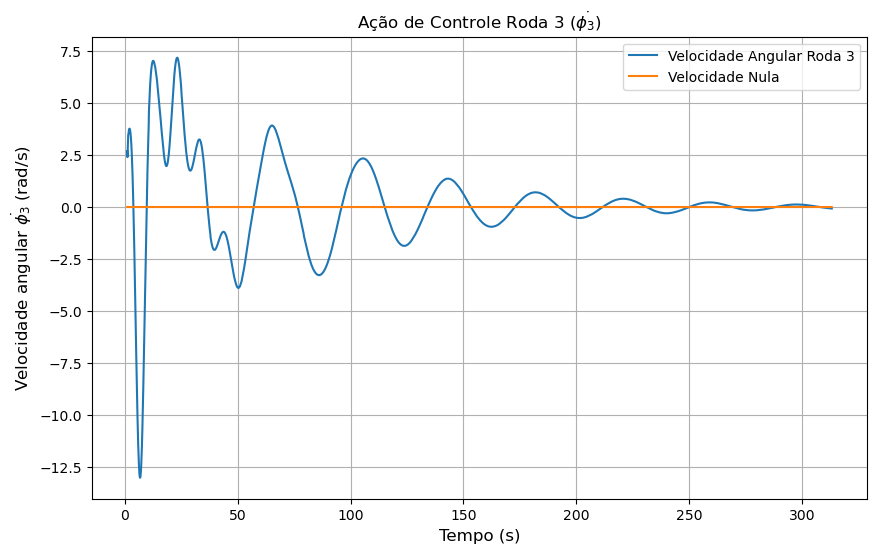

In [13]:
x = np.linspace(1, len(lista_u2)*loop_duration, num = len(lista_u2))
plt.figure(figsize = (10, 6))

plt.plot(x,lista_u2)
plt.plot(x,0*np.ones(len(lista_u2)))
plt.title('Ação de Controle Roda 3 ($\dot{\phi_3}$)')
plt.ylabel('Velocidade angular $\dot{\phi_3}$ (rad/s)', fontsize = 12)
plt.xlabel('Tempo (s)', fontsize = 12)
plt.grid(True)
plt.legend(['Velocidade Angular Roda 3','Velocidade Nula'])
#  
plt.show()

In [1]:
import csv
import numpy as np

In [2]:
def ler_dados_de_csv(nome_arquivo):
    lista_q0 = []
    lista_q1 = []
    lista_q2 = []
    lista_u0 = []
    lista_u1 = []
    lista_u2 = []
    lista_erro_posicao = []

    with open(nome_arquivo, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Pula o cabeçalho
        for row in reader:
            lista_q0.append(float(row[0]))
            lista_q1.append(float(row[1]))
            lista_q2.append(float(row[2]))
            lista_u0.append(float(row[3]))
            lista_u1.append(float(row[4]))
            lista_u2.append(float(row[5]))
            lista_erro_posicao.append(float(row[6]))

    return lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao

In [12]:
 goal = np.array([2, 2, 3.1415])
qgoal[2]

3.141592653589793

In [14]:

def calcular_assentamento_e_sobressinal(dados, valor_final, faixa_percentual=0.05):
    """
    Calcula o tempo de assentamento e o máximo sobressinal para os dados fornecidos.
    
    :param dados: Lista de dados da trajetória.
    :param valor_final: Valor final esperado da trajetória.
    :param faixa_percentual: Percentual da faixa de tolerância para o tempo de assentamento.
    :return: tempo_de_assentamento, maximo_sobressinal
    """
    faixa_superior = valor_final * (1 + faixa_percentual)
    faixa_inferior = valor_final * (1 - faixa_percentual)
    
    tempo_de_assentamento = None
    maximo_sobressinal = -np.inf
    
    for i, valor in enumerate(dados):
        if valor > maximo_sobressinal:
            maximo_sobressinal = valor
        
        if abs(valor - valor_final) / abs(valor_final) > faixa_percentual:
            tempo_de_assentamento = None
        else:
            if tempo_de_assentamento is None:
                tempo_de_assentamento = i
    
    maximo_sobressinal = ((maximo_sobressinal - valor_final) / abs(valor_final)) * 100
    
    return tempo_de_assentamento, maximo_sobressinal

# Exemplo de uso:
nome_arquivo = 'dados_simulacao_PI.csv'
lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao = ler_dados_de_csv(nome_arquivo)

valor_final_q0 = qgoal[0]
valor_final_q1 = qgoal[1]
valor_final_q2 = qgoal[2]

ts_q0, mp_q0 = calcular_assentamento_e_sobressinal(lista_q0, valor_final_q0)
ts_q1, mp_q1 = calcular_assentamento_e_sobressinal(lista_q1, valor_final_q1)
ts_q2, mp_q2 = calcular_assentamento_e_sobressinal(lista_q2, valor_final_q2)

print(f"Tempo de Assentamento q0: {ts_q0*0.1} segundos, Máximo Sobressinal q0: {mp_q0:.2f}%")
print(f"Tempo de Assentamento q1: {ts_q1*0.1} segundos, Máximo Sobressinal q1: {mp_q1:.2f}%")
print(f"Tempo de Assentamento q2: {ts_q2*0.1} segundos, Máximo Sobressinal q2: {mp_q2:.2f}%")

AttributeError: 'list' object has no attribute 'abs'

In [12]:
import numpy as np
import csv
import matplotlib.pyplot as plt

# Função para salvar dados em um arquivo CSV
def salvar_dados_em_csv(nome_arquivo, lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao):
    with open(nome_arquivo, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Escreve o cabeçalho
        writer.writerow(["q0", "q1", "q2", "u0", "u1", "u2", "erro_posicao"])
        
        # Escreve os dados
        for q0, q1, q2, u0, u1, u2, erro_pos in zip(lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao):
            writer.writerow([q0, q1, q2, u0, u1, u2, erro_pos])

# Função para ler dados de um arquivo CSV e atribuir às variáveis correspondentes
def ler_dados_de_csv(nome_arquivo):
    lista_q0 = []
    lista_q1 = []
    lista_q2 = []
    lista_u0 = []
    lista_u1 = []
    lista_u2 = []
    lista_erro_posicao = []

    with open(nome_arquivo, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Pula o cabeçalho
        for row in reader:
            lista_q0.append(float(row[0]))
            lista_q1.append(float(row[1]))
            lista_q2.append(float(row[2]))
            lista_u0.append(float(row[3]))
            lista_u1.append(float(row[4]))
            lista_u2.append(float(row[5]))
            lista_erro_posicao.append(float(row[6]))

    return lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao

# Função para calcular o tempo de assentamento, máximo sobressinal e tempo de subida
def calcular_criterios_resposta(dados, valor_final, faixa_percentual=0.05, tempo_iteracao=0.1):
    faixa_superior = valor_final * (1 + faixa_percentual)
    faixa_inferior = valor_final * (1 - faixa_percentual)
    
    tempo_de_assentamento = None
    maximo_sobressinal = -np.inf
    tempo_de_subida = None
    
    atingiu_10_porcento = False
    tempo_10_porcento = 0
    tempo_90_porcento = 0

    for i, valor in enumerate(dados):
        if valor > maximo_sobressinal:
            maximo_sobressinal = valor
        
        if abs(valor - valor_final) / abs(valor_final) > faixa_percentual:
            tempo_de_assentamento = None
        else:
            if tempo_de_assentamento is None:
                tempo_de_assentamento = i * tempo_iteracao  # Converte para segundos
        
        # Cálculo do tempo de subida
        if not atingiu_10_porcento and valor >= 0.1 * valor_final:
            tempo_10_porcento = i * tempo_iteracao
            atingiu_10_porcento = True
        if atingiu_10_porcento and valor >= 0.9 * valor_final:
            tempo_90_porcento = i * tempo_iteracao
            break

    if tempo_90_porcento > 0:
        tempo_de_subida = tempo_90_porcento - tempo_10_porcento
    
    maximo_sobressinal = ((maximo_sobressinal - valor_final) / abs(valor_final)) * 100
    
    return tempo_de_assentamento, maximo_sobressinal, tempo_de_subida

# Exemplo de uso para ler os dados
nome_arquivo = 'dados_simulacao_p3.csv'
lista_q0, lista_q1, lista_q2, lista_u0, lista_u1, lista_u2, lista_erro_posicao = ler_dados_de_csv(nome_arquivo)

valor_final_q0 = lista_q0[-1]
valor_final_q1 = lista_q1[-1]
valor_final_q2 = lista_q2[-1]

ts_q0, mp_q0, tr_q0 = calcular_criterios_resposta(lista_q0, valor_final_q0)
ts_q1, mp_q1, tr_q1 = calcular_criterios_resposta(lista_q1, valor_final_q1)
ts_q2, mp_q2, tr_q2 = calcular_criterios_resposta(lista_q2, valor_final_q2)

print(f"Tempo de Assentamento q0: {ts_q0} segundos, Máximo Sobressinal q0: {mp_q0:.2f}%, Tempo de Subida q0: {tr_q0} segundos")
print(f"Tempo de Assentamento q1: {ts_q1} segundos, Máximo Sobressinal q1: {mp_q1:.2f}%, Tempo de Subida q1: {tr_q1} segundos")
print(f"Tempo de Assentamento q2: {ts_q2} segundos, Máximo Sobressinal q2: {mp_q2:.2f}%, Tempo de Subida q2: {tr_q2} segundos")

# Gráfico de posições (q0, q1, q2)

Tempo de Assentamento q0: None segundos, Máximo Sobressinal q0: -9.95%, Tempo de Subida q0: 33.6 segundos
Tempo de Assentamento q1: None segundos, Máximo Sobressinal q1: -9.97%, Tempo de Subida q1: 34.1 segundos
Tempo de Assentamento q2: None segundos, Máximo Sobressinal q2: 98.92%, Tempo de Subida q2: None segundos
